<a href="https://colab.research.google.com/github/450586509/reinforcement-learning-practice/blob/master/approximate_qlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

利用tensorflow 实现qlearning


In [0]:
import os
os.system('apt-get install -y xvfb')
os.system('wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall18/xvfb -O ../xvfb')
os.system('apt-get install -y python-opengl ffmpeg')
os.system('pip install pyglet==1.2.4')

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [0]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

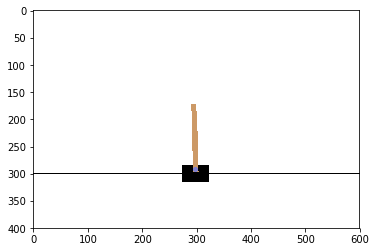

In [61]:
env = gym.make("CartPole-v0").env
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render("rgb_array"))


够着一个简单的网络表示q-table
- 网络的输入为状态s，输出为q(s,a),输出神经元的数量等于action的数量

todo:
- 基于keras实现，两层的全连接网络，hidden_size，分别是[100,100,action_num]
- 不用激励函数。
- 实现get_action(state, network, epsilon=0)
- network如何训练？训练数据？

In [62]:
state_dim

4

In [63]:
import keras
from keras import layers
network = keras.models.Sequential()

sess = tf.InteractiveSession()
keras.backend.set_session(sess)
network.add(layers.Dense(units=128, activation='relu', input_dim=state_dim))
network.add(layers.Dense(units=128, activation='relu'))
network.add(layers.Dense(units=n_actions))
network.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['accuracy'])


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [0]:
import numpy as np
from numpy import random
def get_action(state, epsilon=0):
    """
    sample actions with epsilon-greedy policy
    recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
    """
    s = np.array([state])
    q_values = network.predict(s)[0]
    #print("q_values={0}".format(q_values))
    
    ###YOUR CODE
    best_action = np.argmax(q_values)
    random_actions = random.choice(list(range(len(q_values))),1)
    random_action=random_actions[0]
    flag = random.choice([True, False],1,p=[epsilon, 1-epsilon])
    if flag[0]:
      return random_action
    return best_action

In [0]:
assert network.output_shape == (None, n_actions), "please make sure your model maps state s -> [Q(s,a0), ..., Q(s, a_last)]"
assert network.layers[-1].activation == keras.activations.linear, "please make sure you predict q-values without nonlinearity"
s = env.reset()
assert np.shape(get_action(s)) == (), "please return just one action (integer)"

In [66]:
for eps in [0., 0.1, 0.5, 1.0]:
    state_frequencies = np.bincount([get_action(s, epsilon=eps) for i in range(10000)], minlength=n_actions)
    best_action = state_frequencies.argmax()
    assert abs(state_frequencies[best_action] - 10000 * (1 - eps + eps / n_actions)) < 200
    for other_action in range(n_actions):
        if other_action != best_action:
            assert abs(state_frequencies[other_action] - 10000 * (eps / n_actions)) < 200
    print('e=%.1f tests passed'%eps)

e=0.0 tests passed
e=0.1 tests passed
e=0.5 tests passed
e=1.0 tests passed


### 利用gradient descent 求解qlearning

We shall now train our agent's Q-function by minimizing the TD loss:$$ L = { 1 \over N} \sum_i (Q_{\theta}(s,a) - [r(s,a) + \gamma \cdot max_{a'} Q_{-}(s', a')]) ^2 $$

Where

In [0]:
# Create placeholders for the <s, a, r, s'> tuple and a special indicator for game end (is_done = True)
states_ph = keras.backend.placeholder(dtype='float32', shape=(None,state_dim))
actions_ph = keras.backend.placeholder(dtype='int32', shape=[None])
rewards_ph = keras.backend.placeholder(dtype='float32', shape=[None])
next_states_ph = keras.backend.placeholder(dtype='float32', shape=(None,state_dim))
is_done_ph = keras.backend.placeholder(dtype='bool', shape=[None])

In [0]:
predicted_qvalues = network(states_ph)
#计算action对应的qvalue
import keras.backend as K
predicted_qvalues_for_actions = tf.reduce_sum(K.one_hot(actions_ph, n_actions) * predicted_qvalues, axis=1)


In [0]:
# 在更新值函数的时候用到，平衡reward和下一个状态的值函数
gamma = 0.99
# compute q-values for all actions in next states
predicted_next_qvalues = network(next_states_ph)

next_state_values = K.max(predicted_next_qvalues, axis=-1)
# compute "target q-values" for loss

target_qvalues_for_actions = rewards_ph + (K.max(next_state_values) * gamma)
# tf.where相当于if。当is_done_ph is True时，返回rewards_ph, else：返回tart_qvalues_for_actions。
# tensorflow中实现分支的方法。
import tensorflow as tf
target_qvalues_for_actions = tf.where(is_done_ph, rewards_ph, target_qvalues_for_actions)


### 定义Loss

In [0]:
# 嵌套loss的实现方法。
loss = (predicted_qvalues_for_actions - tf.stop_gradient(target_qvalues_for_actions)) ** 2
loss = tf.reduce_mean(loss)
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

In [0]:
assert tf.gradients(loss, [predicted_qvalues_for_actions])[0] is not None, "make sure you update q-values for chosen actions and not just all actions"
assert tf.gradients(loss, [predicted_next_qvalues])[0] is None, "make sure you don't propagate gradient w.r.t. Q_(s',a')"
assert predicted_next_qvalues.shape.ndims == 2, "make sure you predicted q-values for all actions in next state"
assert next_state_values.shape.ndims == 1, "make sure you computed V(s') as maximum over just the actions axis and not all axes"
assert target_qvalues_for_actions.shape.ndims == 1, "there's something wrong with target q-values, they must be a vector"



In [0]:
def generate_session(t_max=1000, epsilon=0, train=False):
    """play env with approximate q-learning agent and train it at the same time"""
    total_reward = 0
    s = env.reset()
    
    for t in range(t_max):
        a = get_action(s, epsilon=epsilon)       
        next_s, r, done, _ = env.step(a)
        
        if train:
            sess.run(train_step,{
                states_ph: [s], actions_ph: [a], rewards_ph: [r], 
                next_states_ph: [next_s], is_done_ph: [done]
            })

        total_reward += r
        s = next_s
        if done: break
            
    return total_reward

In [0]:

epsilon = 0.5

In [74]:
for i in range(1000):
    session_rewards = [generate_session(epsilon=epsilon, train=True) for _ in range(100)]
    print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}".format(i, np.mean(session_rewards), epsilon))
    
    epsilon *= 0.99
    assert epsilon >= 1e-4, "Make sure epsilon is always nonzero during training"
    
    if np.mean(session_rewards) > 300:
        print ("You Win!")
        break

epoch #0	mean reward = 19.930	epsilon = 0.500
epoch #1	mean reward = 13.620	epsilon = 0.495
epoch #2	mean reward = 13.570	epsilon = 0.490
epoch #3	mean reward = 13.820	epsilon = 0.485
epoch #4	mean reward = 15.120	epsilon = 0.480
epoch #5	mean reward = 21.170	epsilon = 0.475
epoch #6	mean reward = 22.240	epsilon = 0.471
epoch #7	mean reward = 21.480	epsilon = 0.466
epoch #8	mean reward = 35.360	epsilon = 0.461
epoch #9	mean reward = 42.030	epsilon = 0.457
epoch #10	mean reward = 43.270	epsilon = 0.452
epoch #11	mean reward = 45.780	epsilon = 0.448
epoch #12	mean reward = 61.500	epsilon = 0.443
epoch #13	mean reward = 80.420	epsilon = 0.439
epoch #14	mean reward = 114.210	epsilon = 0.434
epoch #15	mean reward = 116.440	epsilon = 0.430
epoch #16	mean reward = 147.430	epsilon = 0.426
epoch #17	mean reward = 148.290	epsilon = 0.421
epoch #18	mean reward = 165.780	epsilon = 0.417
epoch #19	mean reward = 181.860	epsilon = 0.413
epoch #20	mean reward = 190.290	epsilon = 0.409
epoch #21	mean r

### 结果展示
利用grm.wrappers.Monitor录制游戏，方便展示效果

In [0]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),directory="videos",force=True)
sessions = [generate_session(epsilon=0, train=False) for _ in range(100)]
env.close()

In [80]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))


HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

In [79]:
video_names[-1]

'openaigym.video.0.118.video000064.mp4'